In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon
import ast
import folium
from folium import Map
from folium.map import Layer, FeatureGroup,LayerControl,Marker
from folium.plugins import MarkerCluster,FeatureGroupSubGroup,Fullscreen

In [2]:
from utils import *

In [3]:
shopinfo = ShopGeoInfo(shopcode=10)

In [4]:
shops,shop_lat,shop_lng,shop_name = shopinfo.preprocessing()

before drop duplicates 990
after drop duplicates, 912 left
after set max distance to 800m, 716 left


In [5]:
shop_name

'仙台三越(Women)'

In [7]:
geom = [Point(xy) for xy in zip(shops['lng'],shops['lat'])]

In [8]:
shops_gdf = gpd.GeoDataFrame(shops,geometry = geom)
shops_gdf.head()

,business_status,name,lat,lng,user_ratings_total,price_level,distance,types,permanently_closed,rating,geometry
0,OPERATIONAL,Kotodaikoen Station,38.266976,140.871197,64,NaN,207.814508,"['subway_station', 'transit_station', 'point_o...",NaN,3.8,POINT (140.87120 38.26698)
1,OPERATIONAL,Hirosedori Station,38.262782,140.875503,33,NaN,459.402348,"['subway_station', 'transit_station', 'point_o...",NaN,3.5,POINT (140.87550 38.26278)
2,OPERATIONAL,Aoba-dori Ichibancho Sta.,38.259671,140.872225,33,NaN,611.672505,"['subway_station', 'transit_station', 'point_o...",NaN,4.1,POINT (140.87223 38.25967)
70,OPERATIONAL,商工会議所前［仙台市］（バス）,38.264628,140.872255,0,NaN,109.998948,"['transit_station', 'point_of_interest', 'esta...",NaN,0.0,POINT (140.87226 38.26463)
71,OPERATIONAL,Jozenjidori Shiyakushomae Bus Stop,38.265800,140.870100,2,NaN,119.961662,"['transit_station', 'point_of_interest', 'esta...",NaN,4.0,POINT (140.87010 38.26580)


<AxesSubplot:>

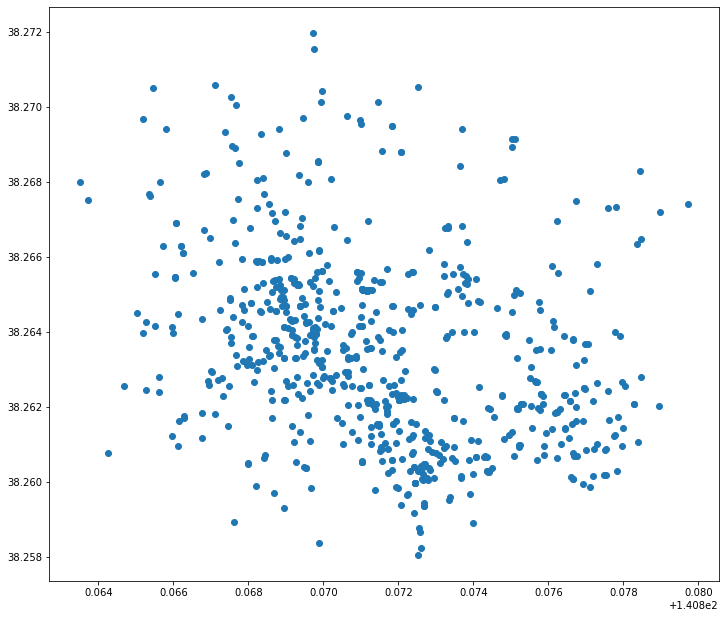

In [9]:
shops_gdf.plot(figsize = (12,12))

In [10]:
type_dict = {}

type_all=['subway station','taxi stand',
'bus station','transit station','atm','beauty salon','bakery',
'bar','restaurant','cafe','night club','shopping mall',
'clothing store','department store','supermarket','hair care',
          'convenience store','parking','bank']

for type_i in type_all:
    type_dict[type_i] = shops_gdf[shops_gdf['types'].str.contains(type_i.split()[0])].reset_index(drop = True)

In [11]:
def make_cmap(n, name='coolwarm'):
    ## name must be a valid cmap name
    ## returns cmap segmented into n-discrete parts
    return plt.cm.get_cmap(name, n)

cmap = make_cmap(len(type_dict),name = 'YlOrRd')

color_dict = {}

for i,code in enumerate(type_dict):
    color = cmap(i)
    color_dict[code] = f"RGB({color[0]*256},{color[1]*256},{color[2]*256})"

In [10]:
#color_dict

In [12]:
## call .info() to have a list of column names to reference, including how many missing values there are
shops_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 716 entries, 0 to 988
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   business_status     716 non-null    object  
 1   name                716 non-null    object  
 2   lat                 716 non-null    float64 
 3   lng                 716 non-null    float64 
 4   user_ratings_total  716 non-null    int64   
 5   price_level         126 non-null    float64 
 6   distance            716 non-null    float64 
 7   types               716 non-null    object  
 8   permanently_closed  2 non-null      float64 
 9   rating              716 non-null    float64 
 10  geometry            716 non-null    geometry
dtypes: float64(6), geometry(1), int64(1), object(3)
memory usage: 67.1+ KB


In [14]:
# let's make a web map
jp_map = folium.Map(location = [shop_lat, shop_lng],
                          zoom_start = 10,
                          tiles = 'Stamen Toner',
                          control_scale=True, 
                          prefer_canvas = True)

Fullscreen(
    title='Expand me',
    title_cancel='Exit fullscreen',
    force_separate_button=True
).add_to(jp_map)
for event in type_dict:
    shop_gdf = type_dict[event].fillna(np.nan)
    if len(shop_gdf)>0:
        def pointcolors(counter):
            return(color_dict[event])

        shop_gdf['color'] = shop_gdf.apply(pointcolors,axis = 1)

        marker_cluster = MarkerCluster(control = False)
        marker_cluster.add_to(jp_map)

        sub_group = FeatureGroupSubGroup(marker_cluster, name = event, control = True, show = True)
        for point in range(0, len(shop_gdf)):
            html = """
                    <h3>{title}</h3><br>
                    <b>User ratings total number:</b> {user_rating_num}<br>
                    <b>User ratings score:</b> {rating}<br>
                    <b>price level:</b> {price_level}<br>
                """
            popup_contents = folium.Html(html.format(title = shop_gdf['name'][point],
                                                         user_rating_num = shop_gdf['user_ratings_total'][point],
                                                         rating = shop_gdf['rating'][point],
                                                     price_level = shop_gdf['price_level'][point]),
                                                     script = True)
            popup = folium.Popup(popup_contents, max_width=2650)

            folium.vector_layers.CircleMarker(radius = 10,
                                                  location = (shop_gdf.geometry[point].y,
                                                              shop_gdf.geometry[point].x),
                                                  popup = popup,
                                                  color = shop_gdf['color'][point],
                                                  fill = True,
                                                  fill_color = shop_gdf['color'][point],
                                                  name = event,
                                                  control = True,
                                                  overlay = True
                                                 ).add_to(sub_group)

    sub_group.add_to(jp_map)
# add the star center 
from folium.plugins import BeautifyIcon
icon_star = BeautifyIcon(
    icon='star',
    inner_icon_style='color:blue;font-size:30px;',
    background_color='transparent',
    border_color='transparent',
)

folium.Marker([shop_lat, shop_lng], tooltip='star', icon=icon_star).add_to(jp_map)
# https://stackoverflow.com/questions/60131314/folium-draw-star-marker
folium.map.LayerControl(collapsed=False).add_to(jp_map)
#jp_map.save('./shop_folium_map_t1.html')
jp_map

In [22]:
jp_map.save('./shop_folium_map_仙台三越v3.html')

In [21]:
jp_map